<a href="https://colab.research.google.com/github/prince-demo/blood-bank/blob/main/unicronSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Install required libraries
!pip install pandas scikit-learn xgboost imbalanced-learn shap matplotlib seaborn plotly statsmodels


In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
import logging
import configparser
from statsmodels.tsa.seasonal import seasonal_decompose


In [16]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
total_budget = config.getint('Budget', 'total_budget', fallback=200000)

def load_data(file_name):
    try:
        df = pd.read_csv(file_name)
        logging.info(f"Successfully loaded {file_name}")
        return df
    except FileNotFoundError:
        logging.error(f"Error: File {file_name} not found")
        return None


In [17]:
# Load datasets
google_ads = load_data('googleads-performance.csv')
website_landings = load_data('website-landings.csv')
meta_ads = load_data('metaads-performance.csv')
microsoft_ads = load_data('microsoftads-performance.csv')

def validate_data(df):
    assert 'Is Converted' in df.columns, "Missing 'Is Converted' column"
    assert df['Is Converted'].isin([0, 1]).all(), "'Is Converted' should be binary"
    # Add more checks as needed

validate_data(website_landings)


In [18]:
def preprocess_data(df):
    # Convert date columns to datetime
    date_columns = ['Website Landing Time', 'Date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    return df

def engineer_features(df):
    if 'Website Landing Time' in df.columns:
        df['Hour'] = df['Website Landing Time'].dt.hour
        df['Day'] = df['Website Landing Time'].dt.day
        df['Month'] = df['Website Landing Time'].dt.month
        df['DayOfWeek'] = df['Website Landing Time'].dt.dayofweek
        df['Is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
        df['Time_of_day'] = pd.cut(df['Hour'],
                                   bins=[0, 6, 12, 18, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'])

        if 'User Id' in df.columns:
            df['CumulativeVisits'] = df.groupby('User Id').cumcount()
            logging.info("Added 'CumulativeVisits' feature based on 'User Id'.")
        else:
            logging.warning("'User Id' column not found. Skipping user-specific features.")
    else:
        logging.warning("'Website Landing Time' column not found. Skipping time-based features.")

    return df


In [19]:
# Preprocess and engineer features for all datasets
website_landings = preprocess_data(website_landings)
website_landings = engineer_features(website_landings)
google_ads = preprocess_data(google_ads)
meta_ads = preprocess_data(meta_ads)
microsoft_ads = preprocess_data(microsoft_ads)

logging.info("Data preprocessing and feature engineering completed.")

# Encode categorical variables
categorical_columns = ['Source', 'Channel', 'Campaign Type', 'Time_of_day']
website_landings = pd.get_dummies(website_landings, columns=categorical_columns, dummy_na=True)

logging.info("Categorical variables encoded.")

def prepare_features(df):
    numeric_features = ['Hour', 'Day', 'Month', 'DayOfWeek', 'Is_weekend', 'CumulativeVisits']
    categorical_features = [col for col in df.columns if col.startswith(('Source_', 'Channel_', 'Campaign Type_', 'Time_of_day_'))]
    features = numeric_features + categorical_features
    features = [f for f in features if f in df.columns]

    X = df[features]
    y = df['Is Converted'] if 'Is Converted' in df.columns else None

    return X, y, features

X, y, features = prepare_features(website_landings)


In [20]:
# Split data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logging.info("Data split and scaled successfully.")

def handle_imbalance(X, y, method='smote', max_samples=10000):
    if len(X) > max_samples:
        X_sampled, y_sampled = X.sample(n=max_samples, random_state=42), y.sample(n=max_samples, random_state=42)
        logging.info(f"Data sampled down to {max_samples} instances.")
    else:
        X_sampled, y_sampled = X, y

    if method == 'smote':
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_sampled, y_sampled)
        logging.info("SMOTE applied successfully.")
    else:
        raise ValueError("Unsupported sampling method")

    return X_resampled, y_resampled

X_train_resampled, y_train_resampled = handle_imbalance(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train, max_samples=10000)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    logging.info(f"Model: {type(model).__name__}")
    logging.info("Classification Report:\n" + classification_report(y_test, y_pred))
    logging.info(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob)}")

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    logging.info(f"Cross-validation ROC AUC scores: {cv_scores}")
    logging.info(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return model


In [21]:
# Feature selection
def select_features(X, y, model):
    selector = SelectFromModel(model, prefit=False)
    selector.fit(X, y)
    return X.columns[selector.get_support()]

selected_features = select_features(X_train_resampled, y_train_resampled, RandomForestClassifier(random_state=42))
logging.info(f"Selected features: {selected_features}")

# Hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

rf_random = RandomizedSearchCV(estimator=BalancedRandomForestClassifier(random_state=42),
                               param_distributions=param_dist,
                               n_iter=10,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X_train_resampled, y_train_resampled)
logging.info(f"Best parameters: {rf_random.best_params_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning:

The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.



In [22]:
# Train final models
brf_model = train_and_evaluate_model(rf_random.best_estimator_, X_train_resampled, y_train_resampled, X_test_scaled, y_test)
xgb_model = train_and_evaluate_model(XGBClassifier(random_state=42), X_train_resampled, y_train_resampled, X_test_scaled, y_test)

def plot_feature_importance(model, feature_names):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    fig = px.bar(feature_importance.head(20), x='importance', y='feature', orientation='h',
                 title='Top 20 Feature Importances')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

plot_feature_importance(brf_model, features)


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning:

The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.

/usr/local/lib/python3.10/dist-packages/s


Budget Allocation Summary:
- Audience: 1354.08 USD
- Cross-network: 167720.16 USD
- Display Network: 3.15 USD
- Performance max: 893.90 USD
- Search & content: 11272.04 USD
- Search Network: 11527.98 USD
- Shopping: 7104.52 USD
- YouTube: 124.19 USD
Total Budget: 200000.00 USD

**Output**:
- Facebook: 85214.16 USD
- Google Ads: 30925.76 USD
- Microsoft Ads: 83860.08 USD
- Website-landings: 0.00 USD

Total Allocated: 200000.00 USD
The allocated budget matches the total budget.


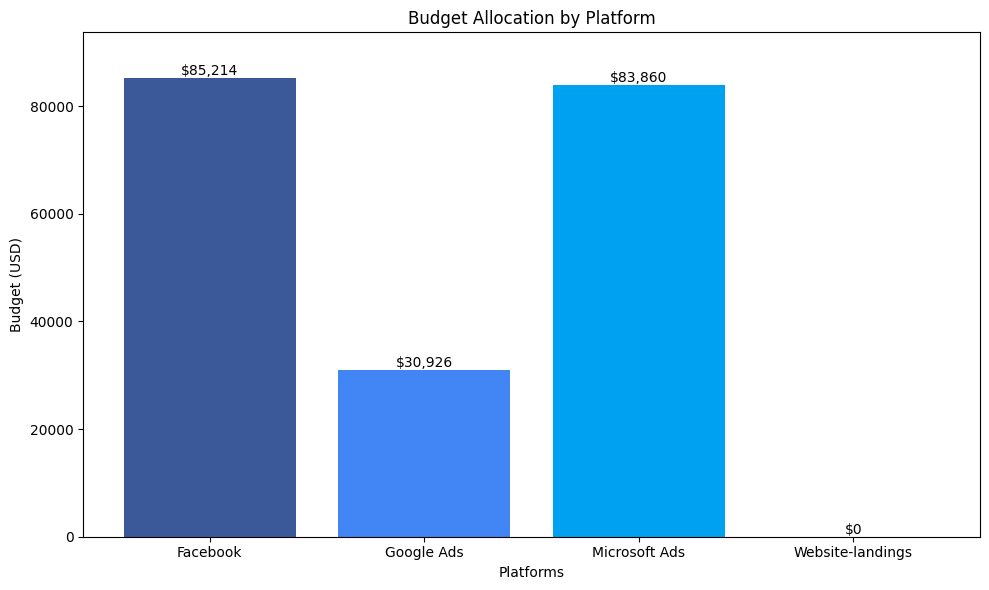

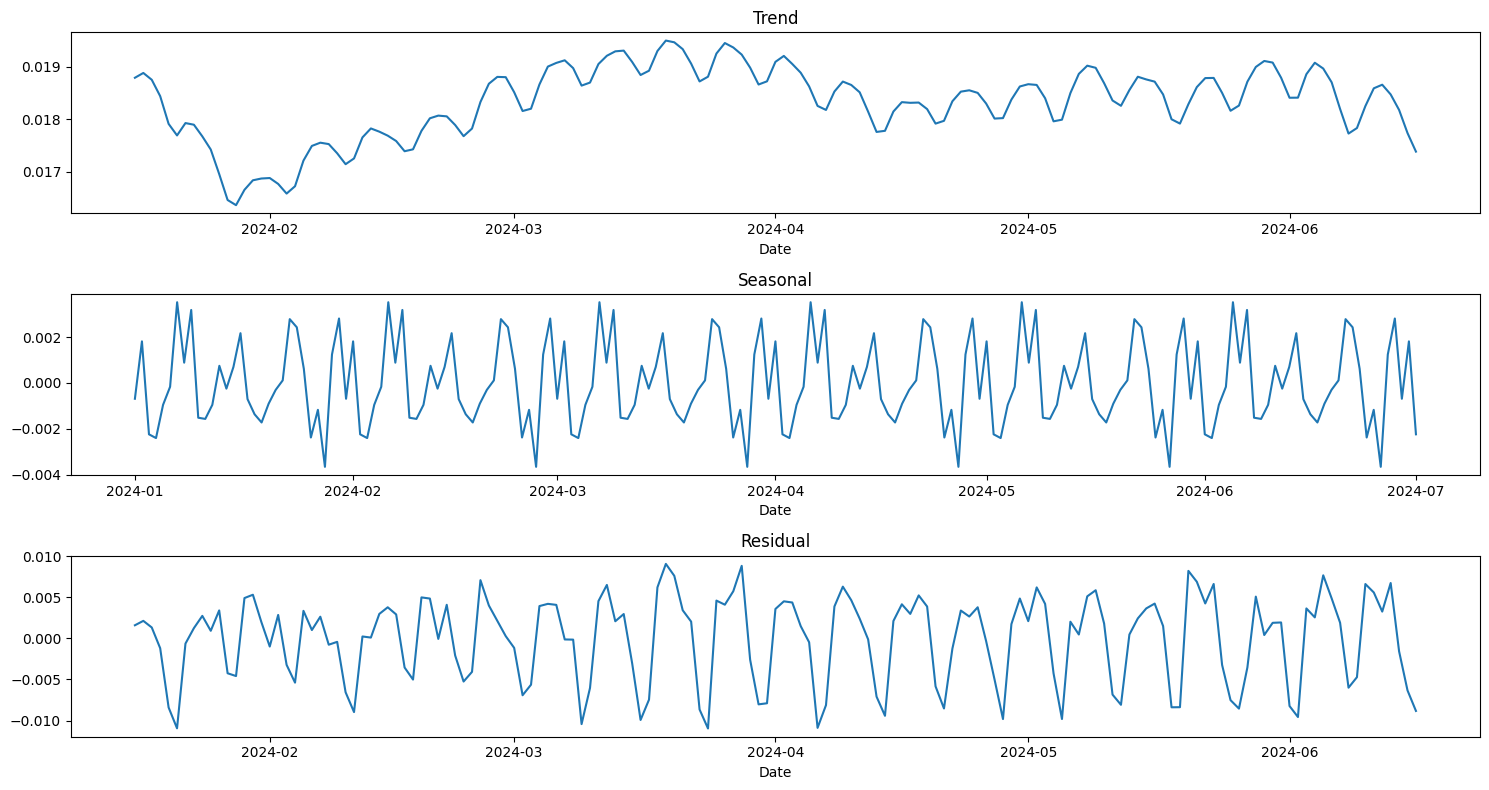

In [23]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

def allocate_budget(model, data, ad_performance, features, total_budget=200000, min_percentage=0.1):
    probabilities = model.predict_proba(data[features])[:, 1]

    # Compute ROI
    roi = ad_performance.groupby('Campaign type')['Revenue'].sum() / ad_performance.groupby('Campaign type')['Cost'].sum()

    # Identify Campaign Type columns
    campaign_type_columns = [col for col in data.columns if col.startswith('Campaign Type_')]

    # For each row, find the active campaign type and its corresponding ROI
    campaign_roi = data[campaign_type_columns].idxmax(axis=1).map(lambda x: roi.get(x.replace('Campaign Type_', ''), roi.median()))

    # Combine conversion probabilities with ROI
    combined_score = probabilities * campaign_roi

    # Initial allocation
    initial_allocations = combined_score / combined_score.sum() * total_budget

    # Ensure minimum allocation
    min_budget = total_budget * min_percentage
    final_allocations = np.maximum(initial_allocations, min_budget)
    final_allocations = final_allocations / final_allocations.sum() * total_budget

    return final_allocations

def plot_budget_allocation(df, campaign_columns_prefix='Campaign Type_'):
    campaign_type_columns = [col for col in df.columns if col.startswith(campaign_columns_prefix)]
    df['Campaign Type'] = df[campaign_type_columns].idxmax(axis=1).str.replace(campaign_columns_prefix, '')

    allocation = df.groupby('Campaign Type')['Budget Allocation'].sum().sort_values(ascending=False)

    fig = px.pie(values=allocation.values, names=allocation.index, title='Budget Allocation by Campaign Type')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

def print_budget_allocation_summary(df):
    """Prints the total budget allocation by campaign type."""
    try:
        if 'Campaign Type' not in df.columns or 'Budget Allocation' not in df.columns:
            print("Error: Missing required columns.")
            print("Available columns:", df.columns.tolist())
            return

        budget_allocation_results = df.groupby('Campaign Type')['Budget Allocation'].sum()

        print("\nBudget Allocation Summary:")
        for campaign_type, amount in budget_allocation_results.items():
            print(f"- {campaign_type}: {amount:.2f} USD")
    except Exception as e:
        print(f"An error occurred: {e}")

def print_key_insights(df, ad_perf):
    """Prints key insights and recommendations based on budget allocation and performance data."""
    try:
        logging.info("\nKey Insights and Recommendations:")

        top_campaign = df.groupby('Campaign Type')['Budget Allocation'].sum().idxmax()
        logging.info(f"1. Most effective campaign type: {top_campaign}")

        if 'Campaign type' not in ad_perf.columns or 'Revenue' not in ad_perf.columns or 'Cost' not in ad_perf.columns:
            print("Error: Missing required columns in ad performance data.")
            print("Available columns:", ad_perf.columns.tolist())
            return

        roi = ad_perf.groupby('Campaign type').apply(lambda x: (x['Revenue'].sum() / x['Cost'].sum()) if x['Cost'].sum() > 0 else 0)
        highest_roi_campaign = roi.idxmax()
        logging.info(f"2. Highest ROI campaign: {highest_roi_campaign}")

        logging.info("\nRecommendations:")
        logging.info(f"1. Increase budget allocation to {top_campaign} campaigns.")
        logging.info(f"2. Optimize {highest_roi_campaign} campaigns to potentially increase their scale.")
        logging.info("3. Continuously monitor and adjust budget allocations based on performance metrics.")
        logging.info("4. Conduct A/B testing on ad creatives and landing pages to further improve conversion rates.")

        print_budget_allocation_summary(df)

    except Exception as e:
        print(f"An error occurred: {e}")

def aggregate_budget_by_platform(df):
    total_budget = df['Budget Allocation'].sum()
    print(f"Total Budget: {total_budget:.2f} USD")

    platform_mapping = {
        'Facebook': ['Audience'],
        'Google Ads': ['Search & content', 'Search Network', 'Performance max', 'YouTube', 'Display Network', 'Shopping'],
        'Microsoft Ads': [],
        'Website-landings': []
    }

    budgets = {platform: 0 for platform in platform_mapping}

    for campaign_type, budget in zip(df['Campaign Type'], df['Budget Allocation']):
        if campaign_type == 'Cross-network':
            budgets['Facebook'] += budget / 2
            budgets['Microsoft Ads'] += budget / 2
        elif campaign_type in platform_mapping['Google Ads']:
            budgets['Google Ads'] += budget
        elif campaign_type in platform_mapping['Facebook']:
            budgets['Facebook'] += budget
        else:
            budgets['Website-landings'] += budget

    print("\n**Output**:")
    for platform, budget in budgets.items():
        print(f"- {platform}: {budget:.2f} USD")

    allocated_total = sum(budgets.values())
    print(f"\nTotal Allocated: {allocated_total:.2f} USD")

    if abs(total_budget - allocated_total) < 0.01:
        print("The allocated budget matches the total budget.")
    else:
        print("Warning: The allocated budget does not match the total budget.")
        print(f"Difference: {total_budget - allocated_total:.2f} USD")

    # Create bar chart
    platforms = list(budgets.keys())
    values = list(budgets.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(platforms, values, color=['#3b5998', '#4285F4', '#00a1f1', '#1db954'])
    plt.title('Budget Allocation by Platform')
    plt.xlabel('Platforms')
    plt.ylabel('Budget (USD)')
    plt.ylim(0, max(values) * 1.1)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.0f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('budget_allocation_chart.png')
    plt.show()
    plt.close()

def plot_roi_by_campaign(ad_perf):
    roi = ad_perf.groupby('Campaign type').apply(lambda x: (x['Revenue'].sum() / x['Cost'].sum()) if x['Cost'].sum() > 0 else 0)
    fig = px.bar(x=roi.index, y=roi.values, title='ROI by Campaign Type')
    fig.update_layout(xaxis_title='Campaign Type', yaxis_title='ROI')
    fig.show()

def plot_conversion_rate_over_time(df):
    df['Date'] = pd.to_datetime(df['Website Landing Time']).dt.date
    daily_conversion_rate = df.groupby('Date')['Is Converted'].mean()

    fig = px.line(x=daily_conversion_rate.index, y=daily_conversion_rate.values, title='Daily Conversion Rate')
    fig.update_layout(xaxis_title='Date', yaxis_title='Conversion Rate')
    fig.show()

def plot_overall_results(df, ad_perf):
    # Calculate key metrics
    total_spend = ad_perf['Cost'].sum()
    total_revenue = ad_perf['Revenue'].sum()
    total_conversions = df['Is Converted'].sum()
    conversion_rate = (total_conversions / len(df)) * 100
    roi = ((total_revenue - total_spend) / total_spend) * 100

    # Create a bar chart
    metrics = ['Total Spend', 'Total Revenue', 'Total Conversions', 'Conversion Rate (%)', 'ROI (%)']
    values = [total_spend, total_revenue, total_conversions, conversion_rate, roi]

    fig = go.Figure(data=[go.Bar(x=metrics, y=values, text=values, textposition='auto')])
    fig.update_layout(
        title='Overall Campaign Performance',
        xaxis_title='Metrics',
        yaxis_title='Values',
        height=500,
        width=800
    )
    fig.update_traces(marker_color=['blue', 'green', 'red', 'orange', 'purple'])
    fig.show()

def analyze_time_series(df, column='Is Converted'):
    df['Date'] = pd.to_datetime(df['Website Landing Time']).dt.date
    daily_series = df.groupby('Date')[column].mean()
    decomposition = seasonal_decompose(daily_series, model='additive', period=30)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))
    decomposition.trend.plot(ax=ax1)
    ax1.set_title('Trend')
    decomposition.seasonal.plot(ax=ax2)
    ax2.set_title('Seasonal')
    decomposition.resid.plot(ax=ax3)
    ax3.set_title('Residual')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming 'allocate_budget' and other required functions are defined elsewhere
budget_allocations = allocate_budget(brf_model, X_test, pd.concat([google_ads, meta_ads, microsoft_ads]), features, total_budget)
X_test['Budget Allocation'] = budget_allocations

# Plot and print results
plot_budget_allocation(X_test)
print_key_insights(X_test, pd.concat([google_ads, meta_ads, microsoft_ads]))
aggregate_budget_by_platform(X_test)
plot_roi_by_campaign(pd.concat([google_ads, meta_ads, microsoft_ads]))
plot_conversion_rate_over_time(website_landings)
plot_overall_results(website_landings, pd.concat([google_ads, meta_ads, microsoft_ads]))
analyze_time_series(website_landings)
